In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, exposure, measure, morphology, util
from segmentflow import segment, view
%load_ext autoreload
%autoreload 2

## Load images

Loading images...
--> Images loaded as 3D array:  (1016, 1024, 1004)
Plotting images: [250, 500, 750]


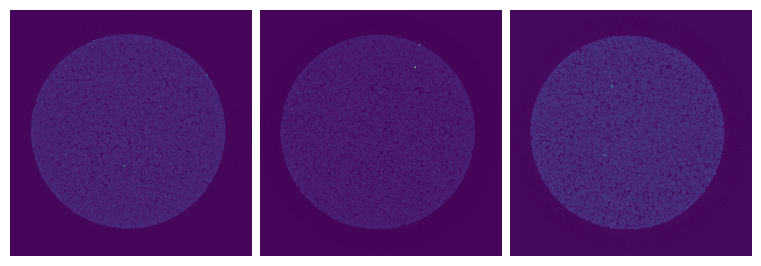

In [3]:
imgs_path = Path('../data/F67tiff')
slices = [250, 500, 750]
imgs = segment.load_images(
    imgs_path,
    slice_crop=None,
    convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = view.plot_slices(
    imgs,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

In [4]:
imgs_med = segment.preprocess(imgs, median_filter=True)

Preprocessing images...
--> Applying median filter...
--> Preprocessing complete
Preprocessing images...
--> Rescaling intensities to percentile range [1, 99]...
--> Preprocessing complete


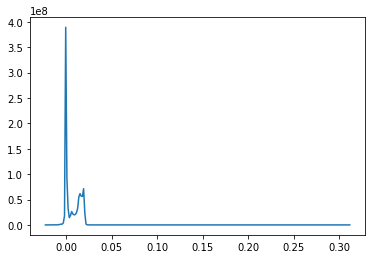

In [5]:
med_hist, med_bins_centers = exposure.histogram(imgs_med)
fig, ax = plt.subplots()
ax.plot(med_bins_centers, med_hist)

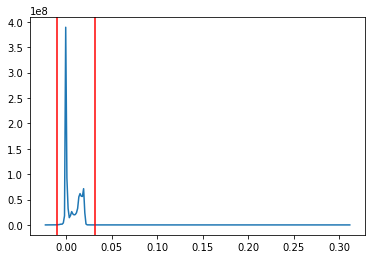

In [6]:
p0x01 = np.percentile(imgs_med, 0.01)
p99x99 = np.percentile(imgs_med, 99.99)
fig, ax = plt.subplots()
ax.plot(med_bins_centers, med_hist)
ax.axvline(p0x01, c='red')
ax.axvline(p99x99, c='red')
plt.show()

## Rescale intensity

Preprocessing images...
--> Rescaling intensities to percentile range [0.01, 99.99]...
--> Preprocessing complete
Plotting images: [250, 500, 750]


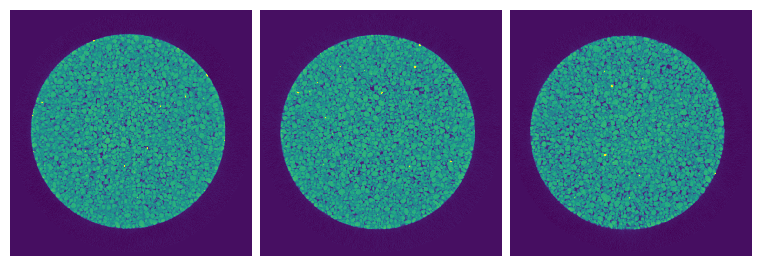

In [7]:
imgs_res = segment.preprocess(imgs_med, rescale_intensity_range=[0.01, 99.99])
fig, axes = view.plot_slices(
    imgs_res,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

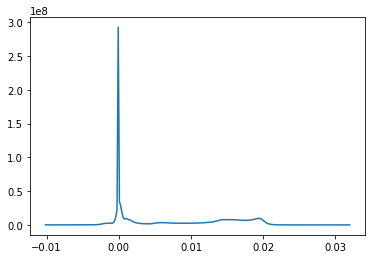

In [8]:
# Clip low & high intensities
imgs_clip = np.clip(imgs_med, p0x01, p99x99)
hist, hist_centers = exposure.histogram(imgs_clip)
fig, ax = plt.subplots()
ax.plot(hist_centers, hist)
plt.show()

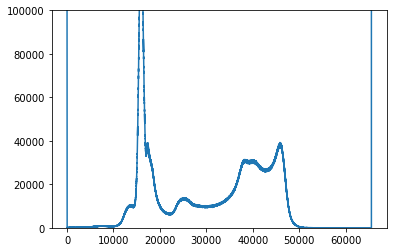

In [17]:
img_res = exposure.rescale_intensity(
    imgs_clip, in_range=(imgs_clip.min(), imgs_clip.max()), out_range='uint16'
)
hist, hist_centers = exposure.histogram(img_res)
fig, ax = plt.subplots()
ax.plot(hist_centers, hist)
ax.set_ylim([0, 1e5])
plt.show()

Plotting images: [250, 500, 750]


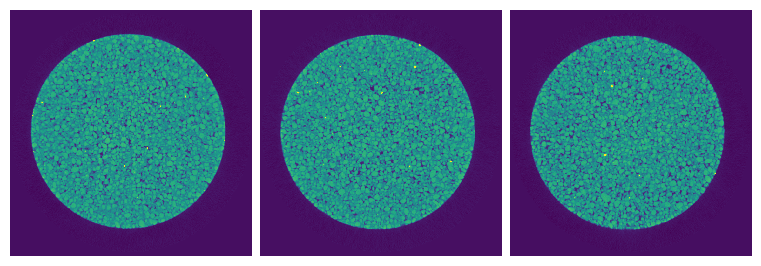

In [11]:
fig, axes = view.plot_slices(
    imgs_clip,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

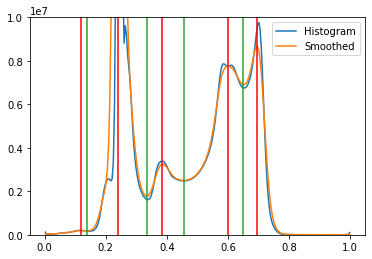

In [26]:
imgs = imgs_res
nbins = 256
if imgs.dtype != float:
    imgs = util.img_as_float32(imgs)
# Calculate histogram
hist, hist_centers = exposure.histogram(imgs, nbins=nbins)
# Smooth histogram with Gaussian filter
hist_smooth = scipy.ndimage.gaussian_filter(hist, 3)
# Find local maxima in smoothed histogram
peaks, peak_props = scipy.signal.find_peaks(hist_smooth)
peaks_adjusted = [hist_centers[i] for i in peaks]
# Find minima between each neighboring pair of local maxima
mins = []
for i in range(1, len(peaks)):
    min_sub_i = np.argmin(hist_smooth[peaks[i - 1] : peaks[i]])
    mins.append(min_sub_i + peaks[i - 1])
mins = [hist_centers[i] for i in mins]
# Plot peaks & mins on histograms
fig, ax = plt.subplots()
ax.plot(hist_centers, hist, label='Histogram')
ax.plot(hist_centers, hist_smooth, c='C1', label='Smoothed')
ax.set_ylim([0, 1e7])
for p in peaks_adjusted:
    ax.axvline(p, c='red')
for m in mins:
    ax.axvline(m, c='C2')
ax.legend()
plt.show()

## Compare to multi-Otsu threshold

Binarizing images...
--> Calculating Otsu threshold(s)...
--> Binarization complete.


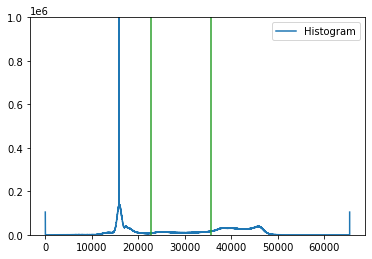

In [28]:
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
    imgs_res, n_otsu_classes=3
)
# Plot peaks & mins on histograms
hist, hist_centers = exposure.histogram(imgs_res)
fig, ax = plt.subplots()
ax.plot(hist_centers, hist, label='Histogram')
ax.set_ylim([0, 1e5])
for val in thresh_vals:
    ax.axvline(val, c='C2')
ax.legend()
plt.show()

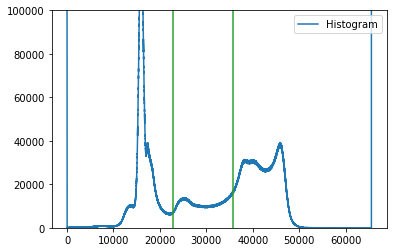

In [29]:
fig, ax = plt.subplots()
ax.plot(hist_centers, hist, label='Histogram')
ax.set_ylim([0, 1e5])
for val in thresh_vals:
    ax.axvline(val, c='C2')
ax.legend()
plt.show()